In [1]:
import mlxtend

In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

# All the tables and their shape

In [4]:
# Execute the query to get the table names
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Get all results
tables = cur.fetchall()

# Get the shape (rows and columns) of each table by running the for loop
table_shapes = {}
for table in tables:
    table_name = table[0]
    
    # Count the number of rows
    cur.execute(f"SELECT COUNT(*) FROM {table_name};")
    row_count = cur.fetchone()[0]
    
    # Count the number of columns
    cur.execute(f"PRAGMA table_info({table_name});")
    columns = cur.fetchall()
    column_count = len(columns)
    
    # Store the shape in the dictionary
    table_shapes[table_name] = (row_count, column_count)

# Print the table names and their shapes
for table, shape in table_shapes.items():
    print(f"Table '{table}' has a shape of {shape}")

Table 'accident' has a shape of (461352, 36)
Table 'casualty' has a shape of (600332, 19)
Table 'vehicle' has a shape of (849091, 28)
Table 'lsoa' has a shape of (34378, 7)


In [5]:
# Making a dictionary to store columns for each table
table_columns = {}

# Looping through each table and get its columns
for table in tables:
    table_name = table[0]
    
    # Get column information
    col_info = cur.execute(f"PRAGMA table_info({table_name})")
    columns = col_info.fetchall()
    
    # Extract column names
    column_names = [column[1] for column in columns]
    
    # Storing the column names in the dictionary with the table name as key
    table_columns[table_name] = column_names

# Printing the column names for each table in the desired format
for table_name, columns in table_columns.items():
    print(f"{table_name.capitalize()}: {columns}")
    print()  

Accident: ['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'local_authority_district', 'local_authority_ons_district', 'local_authority_highway', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident', 'trunk_road_flag', 'lsoa_of_accident_location']

Casualty: ['casualty_index', 'accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'casualty_reference', 'casualty_class', 'sex_of_casualty', 'age_of_casualty'

# DATA CLEANING

### 2) Cleaning local_authority_district column

In [6]:
# Update Suffolk-specific -1 values in a single step
query2_a_optimized = """
UPDATE accident
SET local_authority_district = 37
WHERE local_authority_district = -1
  AND local_authority_ons_district IN ('E07000244', 'E07000245');
"""
cur.execute(query2_a_optimized)
con.commit()

# Optimize -1 replacements using a JOIN approach
query2_b_optimized = """
WITH ValidLocalAuthority AS (
    SELECT DISTINCT 
        local_authority_ons_district,
        local_authority_highway,
        local_authority_district
    FROM accident
    WHERE local_authority_district != -1
)
UPDATE accident
SET local_authority_district = (
    SELECT v.local_authority_district
    FROM ValidLocalAuthority v
    WHERE v.local_authority_ons_district = accident.local_authority_ons_district
      AND v.local_authority_highway = accident.local_authority_highway
    LIMIT 1
)
WHERE local_authority_district = -1
  AND EXISTS (
    SELECT 1 
    FROM ValidLocalAuthority v
    WHERE v.local_authority_ons_district = accident.local_authority_ons_district
      AND v.local_authority_highway = accident.local_authority_highway
  );
"""
cur.execute(query2_b_optimized)
con.commit()

### 3) Cleaning of local_authority_highway Column

In [7]:
query3 = """
UPDATE accident
SET local_authority_highway = 
    CASE 
        WHEN local_authority_highway = '-1' THEN local_authority_ons_district
        ELSE local_authority_highway
    END;
"""
cur.execute(query3)
con.commit()


### 4) Cleaning speed_limit

In [8]:
query4_optimized = """
WITH ModeSpeedLimit AS (
    SELECT 
        local_authority_district,
        speed_limit,
        COUNT(*) AS frequency
    FROM accident
    WHERE speed_limit != -1
    GROUP BY local_authority_district, speed_limit
),
RankedModes AS (
    SELECT 
        local_authority_district,
        speed_limit
    FROM (
        SELECT 
            local_authority_district,
            speed_limit,
            ROW_NUMBER() OVER (PARTITION BY local_authority_district ORDER BY COUNT(*) DESC) AS rank
        FROM accident
        WHERE speed_limit != -1
        GROUP BY local_authority_district, speed_limit
    ) AS Ranked
    WHERE rank = 1
)
UPDATE accident
SET speed_limit = (
    SELECT r.speed_limit
    FROM RankedModes r
    WHERE r.local_authority_district = accident.local_authority_district
)
WHERE speed_limit = -1
  AND EXISTS (
    SELECT 1
    FROM RankedModes r
    WHERE r.local_authority_district = accident.local_authority_district
  );
"""
cur.execute(query4_optimized)
con.commit()

### 5) Cleaning light_conditions Column

In [9]:
# Making a dataframe to inspect the wrong entries
df_accident = pd.read_sql_query("SELECT * FROM accident", con)
df_accident[df_accident["light_conditions"] == -1]

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [10]:
query5a = """
UPDATE accident
SET light_conditions = 1
WHERE accident_index IN ('201763D084717', '2019983103819')
  AND light_conditions = -1;
"""

query5b = """
UPDATE accident
SET light_conditions = 7
WHERE accident_index = '2020520002488';
"""

# Execute both queries
cur.execute(query5a)
cur.execute(query5b)

con.commit()

### 6) Cleaning weather_conditions column

In [11]:
query6 = """
UPDATE accident
SET weather_conditions = 9
WHERE weather_conditions = -1;
"""

# Execute the query
cur.execute(query6)

# Commit the changes
con.commit()

### 7) Cleaning road_surface_conditions column

In [12]:
query7 = """
UPDATE accident
SET road_surface_conditions = 9
WHERE road_surface_conditions = -1;
"""

# Execute the query
cur.execute(query7)

# Commit the changes
con.commit()

### 8) Cleaning lsoa_of_accident_location column

In [13]:
query8 = """
UPDATE accident
SET lsoa_of_accident_location = "unknown"
WHERE lsoa_of_accident_location = "-1";
"""

# Execute the query
cur.execute(query8)

# Commit the changes
con.commit()

# Tasks for the Final Project

# 1. Are there significant hours of the day, and days of the week, on which accidents occur?

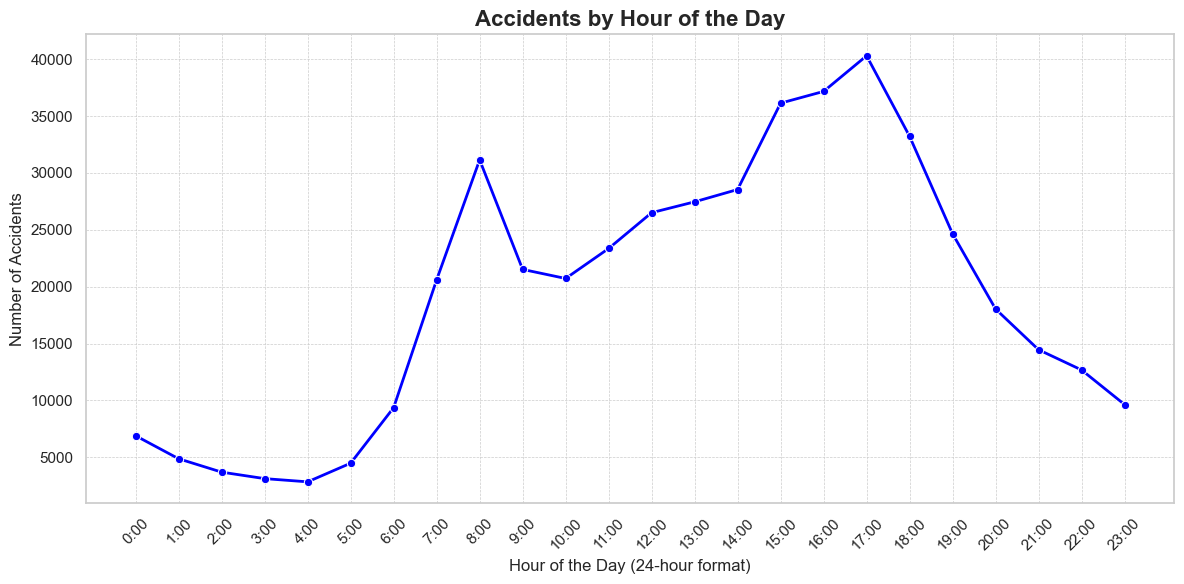

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Query for accidents by hour of the day
cur.execute("""
SELECT
    strftime('%H', 
        substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2) || ' ' || time
    ) AS hour,
    COUNT(*) AS num_accidents
FROM accident
WHERE date IS NOT NULL AND time IS NOT NULL
  AND date != '' AND time != ''
GROUP BY hour
ORDER BY hour;
""")
hourly_accidents = cur.fetchall()

if hourly_accidents:
    # Extract data
    hours, accidents_by_hour = zip(*hourly_accidents)
    
    # Convert hours to integers for sorting
    hours = list(map(int, hours))
    
    # Create figure
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    # Line plot
    sns.lineplot(
        x=hours,
        y=accidents_by_hour,
        marker='o',  # Add markers to emphasize data points
        linewidth=2,
        color='blue'
    )
    
    # Add titles and labels
    plt.title('Accidents by Hour of the Day', fontsize=16, weight='bold')
    plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    
    # Format x-axis ticks
    plt.xticks(range(0, 24), labels=[f"{hour}:00" for hour in range(0, 24)], rotation=45)
    
    # Add grid lines
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for accidents by hour.")

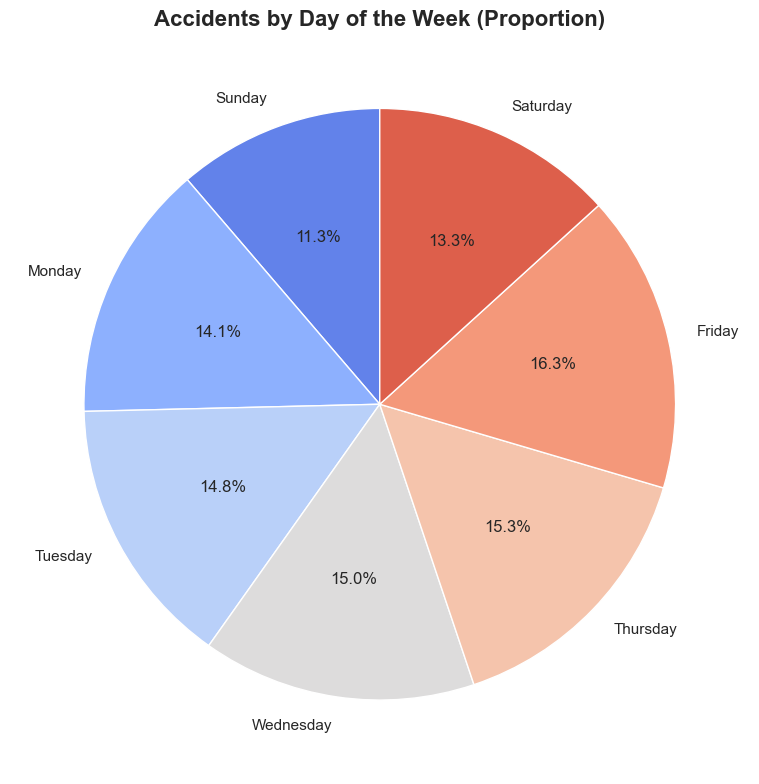

In [15]:
# Query for accidents by day of the week
cur.execute("""
SELECT
    CASE
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '0' THEN 'Sunday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '1' THEN 'Monday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '2' THEN 'Tuesday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '3' THEN 'Wednesday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '4' THEN 'Thursday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '5' THEN 'Friday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '6' THEN 'Saturday'
    END AS day_of_week,
    COUNT(*) AS num_accidents
FROM accident
WHERE date IS NOT NULL AND time IS NOT NULL
  AND date != '' AND time != ''
GROUP BY day_of_week
ORDER BY CASE 
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '0' THEN 1
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '1' THEN 2
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '2' THEN 3
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '3' THEN 4
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '4' THEN 5
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '5' THEN 6
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '6' THEN 7
         END;
""")
weekday_accidents = cur.fetchall()

# If you want to visualize it:
if weekday_accidents:
    days, accidents_by_day = zip(*weekday_accidents)
    
    # Create figure
    plt.figure(figsize=(8, 8))
    sns.set_theme(style="whitegrid")
    
    # Pie chart
    plt.pie(
        accidents_by_day,
        labels=days,
        autopct='%1.1f%%',  # Display percentages
        startangle=90,  # Start from the top
        colors=sns.color_palette('coolwarm', len(days))  # Use a color palette
    )
    
    # Add title
    plt.title('Accidents by Day of the Week (Proportion)', fontsize=16, weight='bold')
    
    # Show plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for accidents by day of the week.")

# 2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.


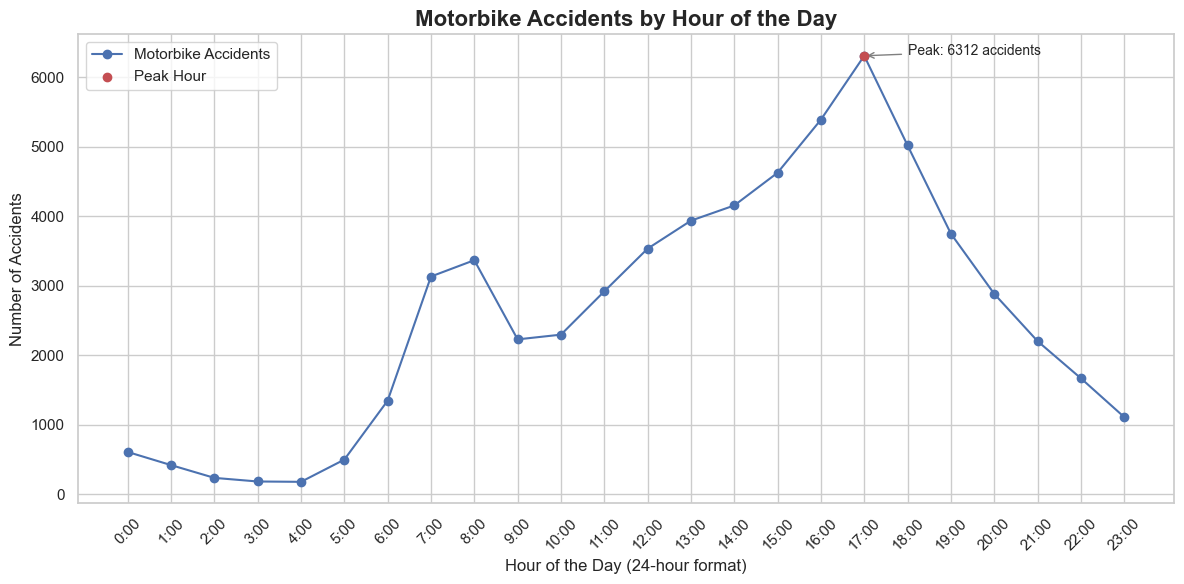

In [16]:
# Query for significant hours of the day for motorcycles
cur.execute("""
SELECT
    strftime('%H', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2) || ' ' || accident.time) AS hour,
    COUNT(*) AS num_accidents
FROM accident
JOIN vehicle ON accident.accident_reference = vehicle.accident_reference
WHERE vehicle.vehicle_type IN (3, 4, 5)  -- Filter for motorcycles: 125cc & under (3), 125cc-500cc (4), and over 500cc (5)
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY hour
ORDER BY hour;
""")
hourly_motorbike_accidents = cur.fetchall()

if hourly_motorbike_accidents:
    # Extract data
    hours, accidents_by_hour = zip(*hourly_motorbike_accidents)
    
    # Convert hours to integers for proper sorting
    hours = list(map(int, hours))
    
    # Create figure
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    # Line plot
    plt.plot(
        hours, 
        accidents_by_hour, 
        marker='o', 
        linestyle='-', 
        color='b', 
        label='Motorbike Accidents'
    )
    
    # Highlight peak hour
    peak_hour_index = accidents_by_hour.index(max(accidents_by_hour))
    plt.scatter(
        [hours[peak_hour_index]], 
        [accidents_by_hour[peak_hour_index]], 
        color='r', 
        zorder=5, 
        label='Peak Hour'
    )
    
    # Add annotations for peak hour
    plt.annotate(
        f"Peak: {max(accidents_by_hour)} accidents",
        (hours[peak_hour_index], accidents_by_hour[peak_hour_index]),
        xytext=(hours[peak_hour_index] + 1, accidents_by_hour[peak_hour_index] + 5),
        arrowprops=dict(arrowstyle="->", color='gray'),
        fontsize=10
    )
    
    # Add titles and labels
    plt.title('Motorbike Accidents by Hour of the Day', fontsize=16, weight='bold')
    plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    
    # Format x-axis ticks
    plt.xticks(range(0, 24), labels=[f"{hour}:00" for hour in range(0, 24)], rotation=45)
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for accidents by hour.")

C:\Users\daniy\AppData\Local\Temp\ipykernel_10448\2840611082.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


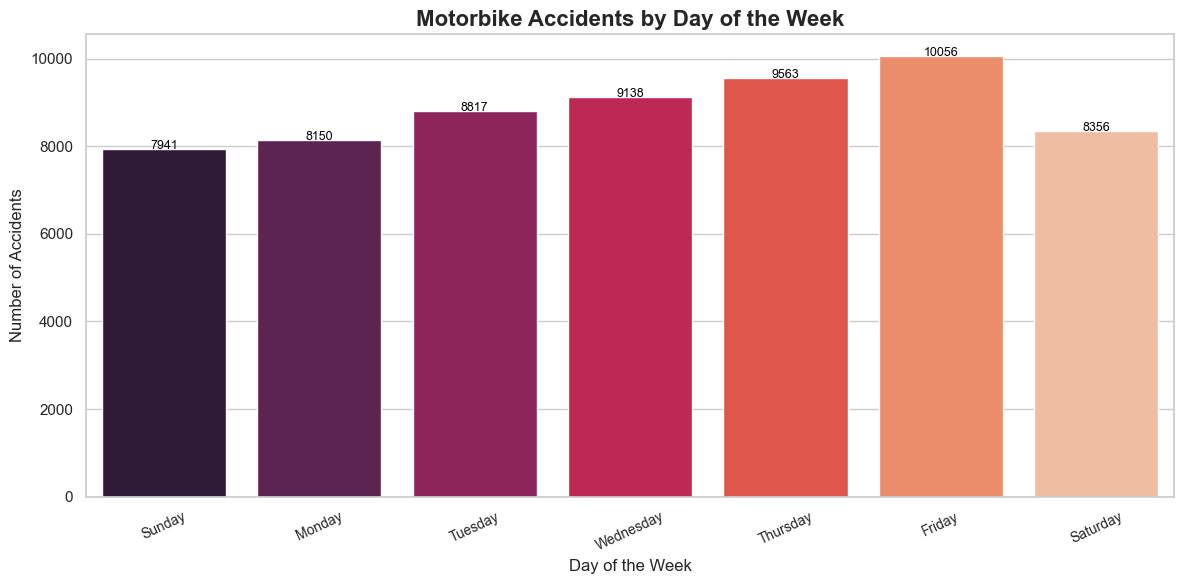

In [17]:
# Query for significant days of the week for motorcycles
cur.execute("""
SELECT
    CASE
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 'Sunday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 'Monday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 'Tuesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 'Wednesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 'Thursday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 'Friday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 'Saturday'
    END AS day_of_week,
    COUNT(*) AS num_accidents
FROM accident
JOIN vehicle ON accident.accident_reference = vehicle.accident_reference
WHERE vehicle.vehicle_type IN (3, 4, 5)  -- Filter for motorcycles: 125cc & under (3), 125cc-500cc (4), and over 500cc (5)
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY day_of_week
ORDER BY CASE
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 1
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 2
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 3
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 4
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 5
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 6
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 7
         END;
""")
weekday_motorbike_accidents = cur.fetchall()

if weekday_motorbike_accidents:
    # Extract data
    days, accidents_by_day = zip(*weekday_motorbike_accidents)
    
    # Explicitly define the order of days
    day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    
    # Create figure
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    # Barplot with ordered days
    bar_plot = sns.barplot(
        x=days, 
        y=accidents_by_day, 
        order=day_order,  # Ensure correct day order
        palette='rocket',  # Use a gradient palette for clarity
        saturation=0.85
    )
    
    # Annotate each bar with the accident count
    for index, count in enumerate(accidents_by_day):
        bar_plot.text(index, count + 0.5, str(count), ha='center', fontsize=9, color='black')
    
    # Add titles and labels
    plt.title('Motorbike Accidents by Day of the Week', fontsize=16, weight='bold')
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    
    # Format x-axis labels
    plt.xticks(rotation=25, fontsize=10)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for accidents by day of the week.")


# 3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

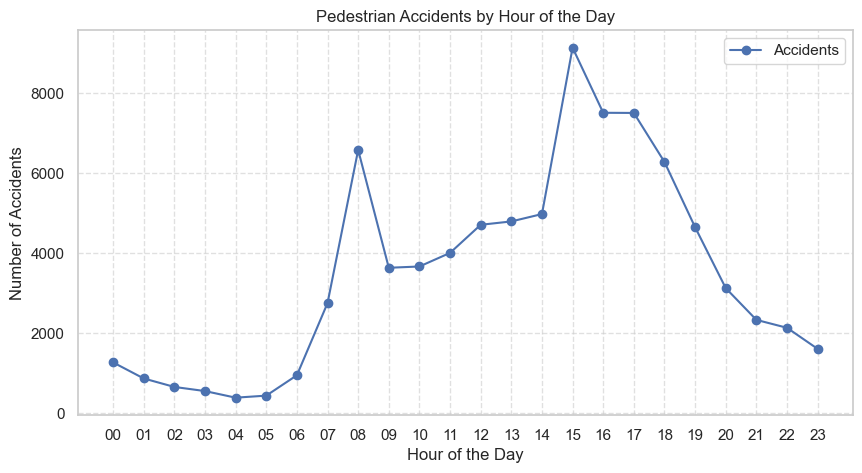

In [18]:
# Query for accidents by hour of the day involving pedestrians
cur.execute("""
SELECT
    strftime('%H', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2) || ' ' || accident.time) AS hour,
    COUNT(*) AS num_accidents
FROM accident
JOIN casualty ON accident.accident_reference = casualty.accident_reference
WHERE casualty.casualty_class = 3  -- Filter for pedestrians
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY hour
ORDER BY hour;
""")
hourly_pedestrian_accidents = cur.fetchall()

# Check if there is data and plot
if hourly_pedestrian_accidents:
    # Unpack the results into hours and accident counts
    hours, accidents_by_hour = zip(*hourly_pedestrian_accidents)
    
    # Plotting the accidents by hour
    plt.figure(figsize=(10, 5))
    plt.plot(hours, accidents_by_hour, marker='o', color='b', linestyle='-', label='Accidents')  # Line graph with markers
    plt.title('Pedestrian Accidents by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(0, 24))  # Display all hours from 0 to 23
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
    plt.legend()
    plt.show()
else:
    print("No data available for pedestrian accidents by hour.")

C:\Users\daniy\AppData\Local\Temp\ipykernel_10448\4056893688.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


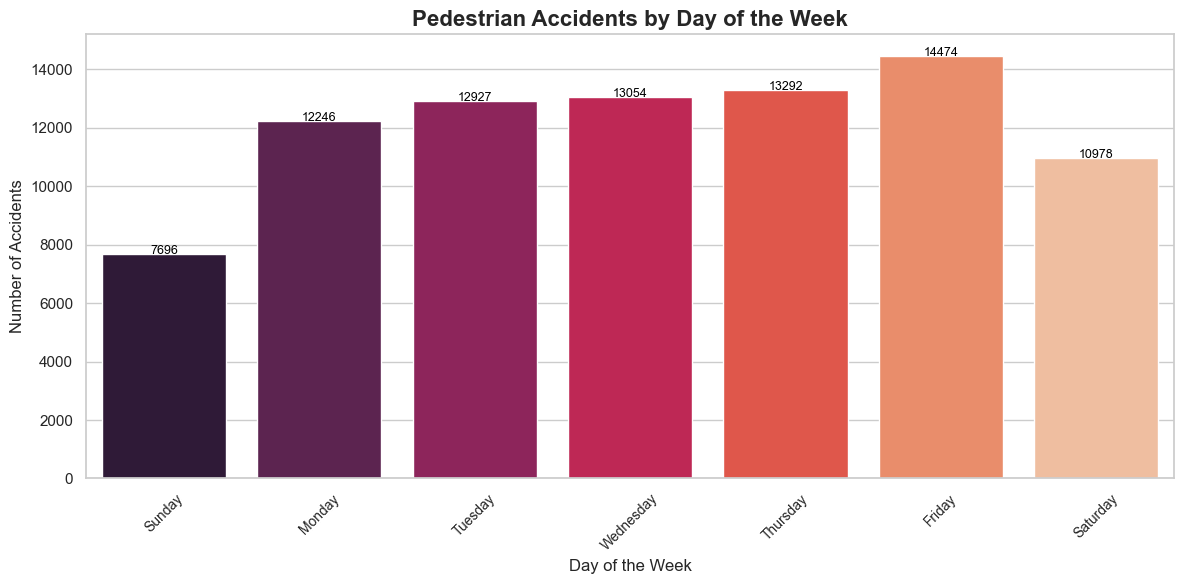

In [19]:
# Query for accidents by day of the week involving pedestrians
cur.execute("""
SELECT
    CASE
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 'Sunday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 'Monday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 'Tuesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 'Wednesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 'Thursday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 'Friday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 'Saturday'
    END AS day_of_week,
    COUNT(*) AS num_accidents
FROM accident
JOIN casualty ON accident.accident_reference = casualty.accident_reference
WHERE casualty.casualty_class = 3  -- Filter for pedestrians
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY day_of_week
ORDER BY CASE
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 1
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 2
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 3
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 4
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 5
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 6
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 7
         END;
""")
weekday_pedestrian_accidents = cur.fetchall()

if weekday_pedestrian_accidents:
    # Extract data into days and accident counts
    days, accidents_by_day = zip(*weekday_pedestrian_accidents)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    # Plot the data
    bar_plot = sns.barplot(
        x=days, 
        y=accidents_by_day, 
        palette='rocket',  # Enhanced color palette
        saturation=0.85
    )
    
    # Add annotations (accident counts above bars)
    for index, count in enumerate(accidents_by_day):
        bar_plot.text(index, count + 0.5, str(count), ha='center', fontsize=9, color='black')
    
    # Add titles and labels
    plt.title('Pedestrian Accidents by Day of the Week', fontsize=16, weight='bold')
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, fontsize=10)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for pedestrian accidents by day of the week.")


# 4. Using the apriori algorithm, explore the impact of selected variables on accident severity.

In [20]:
df_accident = pd.read_sql_query("SELECT * FROM accident", con)

def encode_and_select_columns(df, columns_to_encode):
    """
    Function to apply one-hot encoding to specified columns
    and return a new dataframe with only the encoded columns.
    """
    
    encoded_columns = []  #List to hold encoded columns
    
    # Apply one-hot encoding for each column in the list
    for column in columns_to_encode:
        dummies = pd.get_dummies(df[column], prefix=column).astype(int)
        
        # Append the encoded columns to the list
        encoded_columns.append(dummies)
    
    # Concatenate all the encoded columns into a single dataframe
    encoded_df = pd.concat(encoded_columns, axis=1)
    
    return encoded_df

columns_to_encode = ["accident_severity", "speed_limit", "weather_conditions", "road_surface_conditions", "light_conditions"]

# Apply the function
encoded_df = encode_and_select_columns(df_accident, columns_to_encode)
encoded_df.head()

,accident_severity_1,accident_severity_2,accident_severity_3,speed_limit_20,speed_limit_30,speed_limit_40,speed_limit_50,speed_limit_60,speed_limit_70,weather_conditions_1,...,road_surface_conditions_2,road_surface_conditions_3,road_surface_conditions_4,road_surface_conditions_5,road_surface_conditions_9,light_conditions_1,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7
0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [21]:
from mlxtend.frequent_patterns import apriori, association_rules
freq_item_sets = apriori(encoded_df, min_support=0.2, use_colnames=True)
freq_item_sets.head()

C:\Users\daniy\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.798299,(accident_severity_3)
1,0.595422,(speed_limit_30)
2,0.795436,(weather_conditions_1)
3,0.711372,(road_surface_conditions_1)
4,0.258540,(road_surface_conditions_2)


In [22]:
rules = association_rules(freq_item_sets, metric="lift", min_threshold = 0.5, num_itemsets=len(freq_item_sets) ).sort_values(by='lift', ascending=False) 
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
169,"(road_surface_conditions_1, accident_severity_3)","(weather_conditions_1, speed_limit_30, light_c...",0.567682,0.357582,0.263627,0.464393,1.298705,1.0,0.060635,1.199421,0.532020,0.398448,0.166265,0.600822
164,"(weather_conditions_1, speed_limit_30, light_c...","(road_surface_conditions_1, accident_severity_3)",0.357582,0.567682,0.263627,0.737251,1.298705,1.0,0.060635,1.645366,0.358026,0.398448,0.392232,0.600822
167,"(road_surface_conditions_1, speed_limit_30)","(weather_conditions_1, accident_severity_3, li...",0.435414,0.477499,0.263627,0.605464,1.267991,1.0,0.055718,1.324344,0.374346,0.406027,0.244909,0.578782
166,"(weather_conditions_1, accident_severity_3, li...","(road_surface_conditions_1, speed_limit_30)",0.477499,0.435414,0.263627,0.552101,1.267991,1.0,0.055718,1.260520,0.404498,0.406027,0.206677,0.578782
156,"(weather_conditions_1, accident_severity_3, sp...",(road_surface_conditions_1),0.294010,0.711372,0.263627,0.896662,1.260468,1.0,0.054477,2.793040,0.292701,0.355410,0.641967,0.633626


In [23]:
accident_severity_rules = rules[rules['consequents'].apply(lambda x: any('accident_severity' in str(item) for item in x))]
accident_severity_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
164,"(weather_conditions_1, speed_limit_30, light_c...","(road_surface_conditions_1, accident_severity_3)",0.357582,0.567682,0.263627,0.737251,1.298705,1.0,0.060635,1.645366,0.358026,0.398448,0.392232,0.600822
167,"(road_surface_conditions_1, speed_limit_30)","(weather_conditions_1, accident_severity_3, li...",0.435414,0.477499,0.263627,0.605464,1.267991,1.0,0.055718,1.324344,0.374346,0.406027,0.244909,0.578782
177,(road_surface_conditions_1),"(weather_conditions_1, accident_severity_3, sp...",0.711372,0.294010,0.263627,0.370590,1.260468,1.0,0.054477,1.121670,0.715952,0.355410,0.108472,0.633626
130,"(weather_conditions_1, light_conditions_1)","(road_surface_conditions_1, accident_severity_3)",0.595608,0.567682,0.421630,0.707899,1.247000,1.0,0.083515,1.480030,0.489811,0.568496,0.324338,0.725311
175,"(weather_conditions_1, light_conditions_1)","(road_surface_conditions_1, accident_severity_...",0.595608,0.355893,0.263627,0.442619,1.243685,1.0,0.051655,1.155595,0.484524,0.383250,0.134645,0.591684


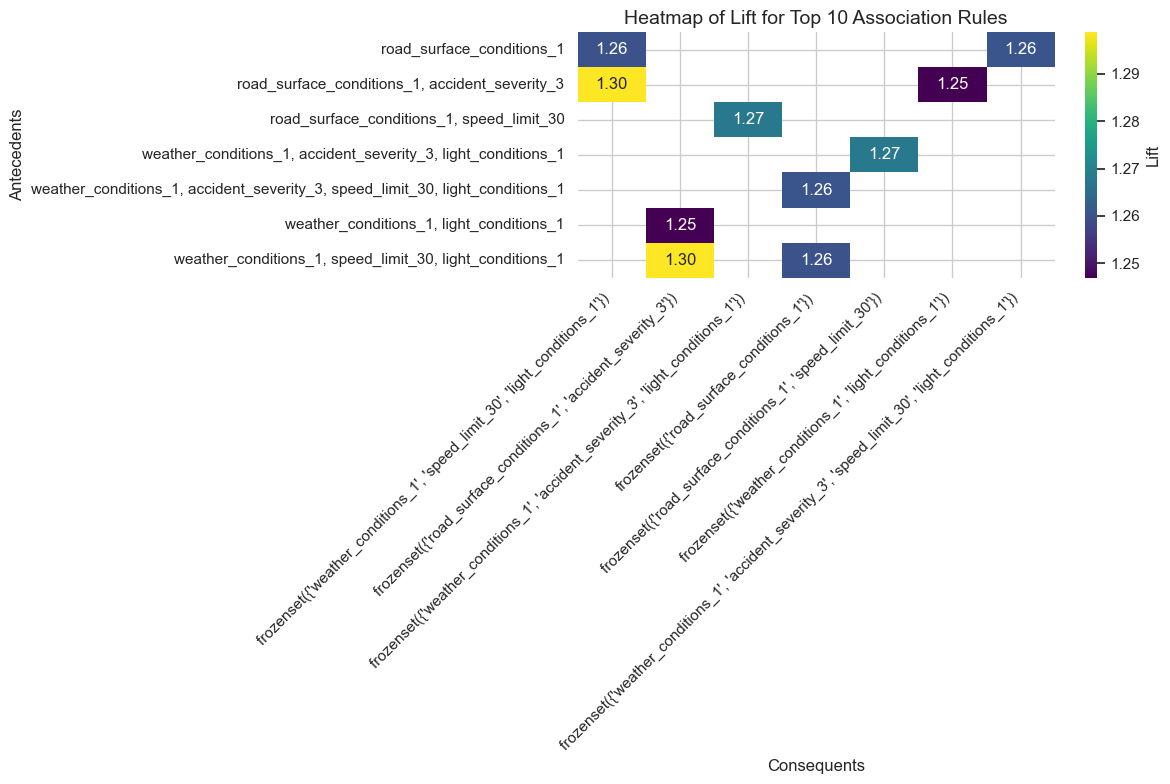

In [24]:
# Sort rules by lift for visualization
top_rules = rules.nlargest(10, 'lift')

# Create a dataframe for the heatmap
heatmap_data = top_rules.pivot_table(
    index=top_rules['antecedents'].apply(lambda x: ', '.join(list(x))),
    columns='consequents',
    values='lift'
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="viridis", 
    cbar_kws={'label': 'Lift'}
)

# Customize the plot
plt.title('Heatmap of Lift for Top 10 Association Rules', fontsize=14)
plt.xlabel('Consequents', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\daniy\AppData\Local\Temp\ipykernel_10448\1765726281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_severity_rules['accident_severity'] = accident_severity_rules['consequents'].apply(


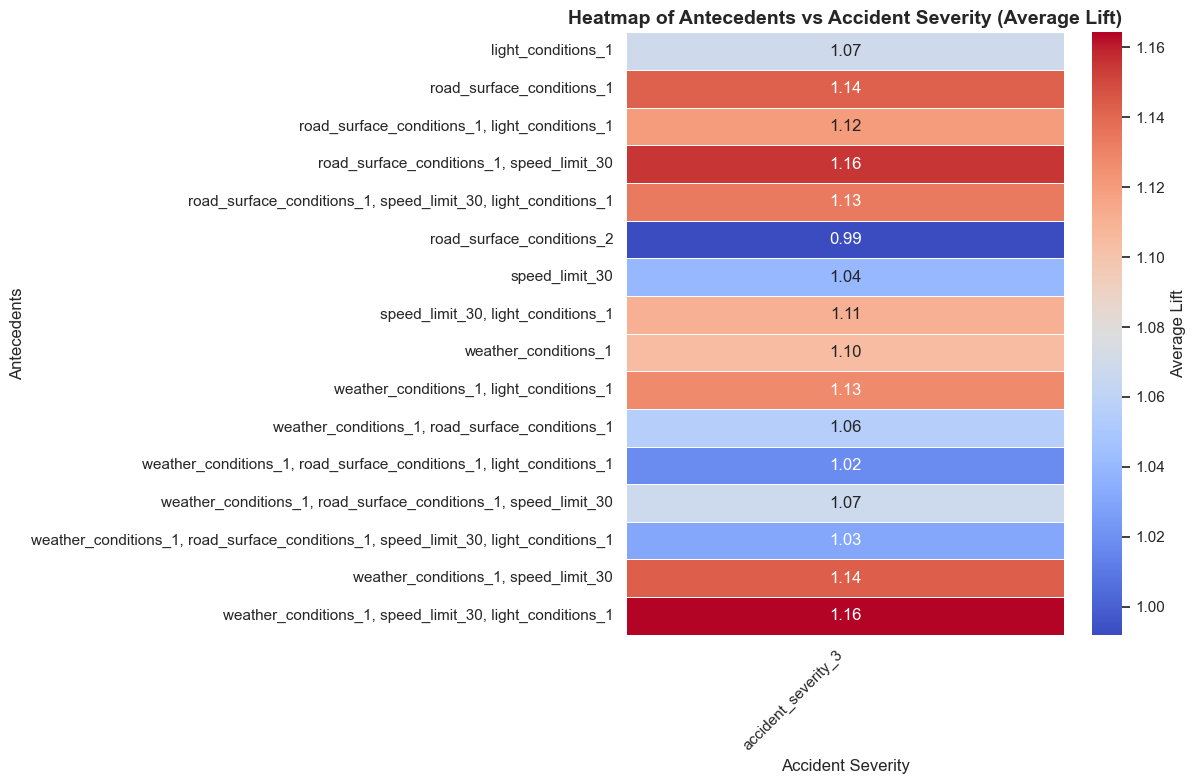

In [25]:
# Extract 'accident_severity' from 'consequents' and add it to the dataframe
accident_severity_rules['accident_severity'] = accident_severity_rules['consequents'].apply(
    lambda x: next((item for item in x if 'accident_severity' in str(item)), None) if isinstance(x, frozenset) else None
)

# Create a pivot table for visualization
heatmap_data = accident_severity_rules.pivot_table(
    index=accident_severity_rules['antecedents'].apply(lambda x: ', '.join(list(x))),
    columns='accident_severity',
    values='lift',
    aggfunc='mean'  # Use mean lift value if there are duplicates
).fillna(0)

# Plotting the improved heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f",  # Display lift values with 2 decimal points
    cmap="coolwarm", 
    linewidths=0.5, 
    cbar_kws={'label': 'Average Lift'}
)

# Customize the plot
plt.title('Heatmap of Antecedents vs Accident Severity (Average Lift)', fontsize=14, weight='bold')
plt.xlabel('Accident Severity', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

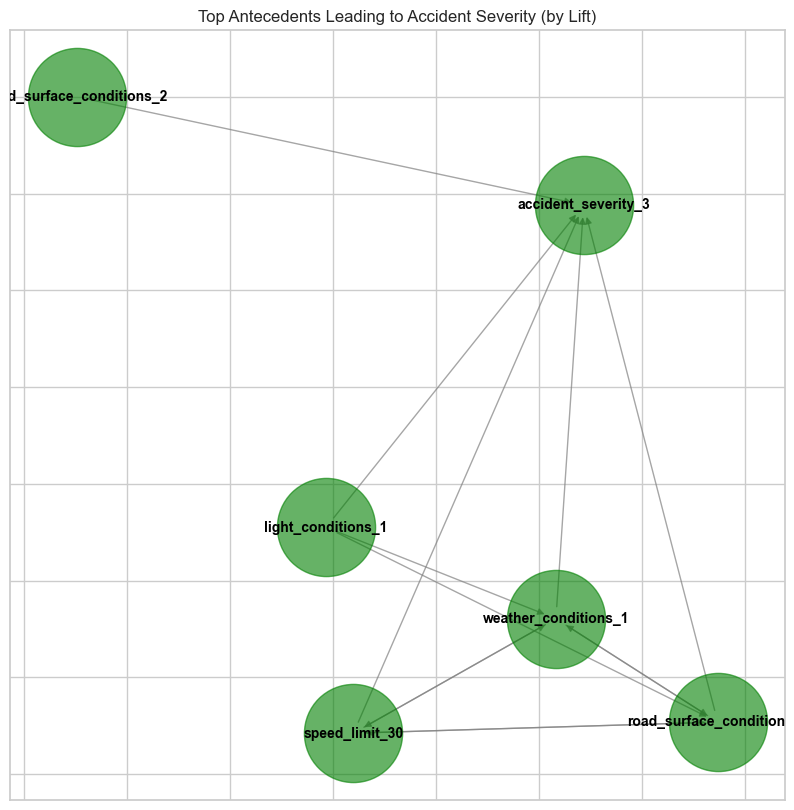

In [26]:
import networkx as nx

#Create a directed graph
G = nx.DiGraph()

#Add edges from the antecedents to the consequents
for index, row in accident_severity_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequent = list(row['consequents'])[0]  # Only one consequent, accident severity
    for antecedent in antecedents:
        G.add_edge(antecedent, consequent, weight=row['lift'])

#Plotting
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Use spring layout for better visualization
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="green", alpha=0.6)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black')
plt.title('Top Antecedents Leading to Accident Severity (by Lift)')
plt.show()

# 5. Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region?

In [27]:
# Filter for East Riding of Yorkshire (E01012919 to E01013127)
query = """
SELECT *
FROM accident
WHERE (lsoa_of_accident_location >= 'E01012756' AND lsoa_of_accident_location <= 'E01012918') 
   OR (lsoa_of_accident_location >= 'E01012919' AND lsoa_of_accident_location <= 'E01013127')
   OR (lsoa_of_accident_location >= 'E01013235' AND lsoa_of_accident_location <= 'E01013334')
   OR (lsoa_of_accident_location >= 'E01013128' AND lsoa_of_accident_location <= 'E01013234');
"""

# Execute the query and fetch the results
df_region = pd.read_sql_query(query, con)

In [28]:
lat_lon = df_region[['longitude','latitude']]

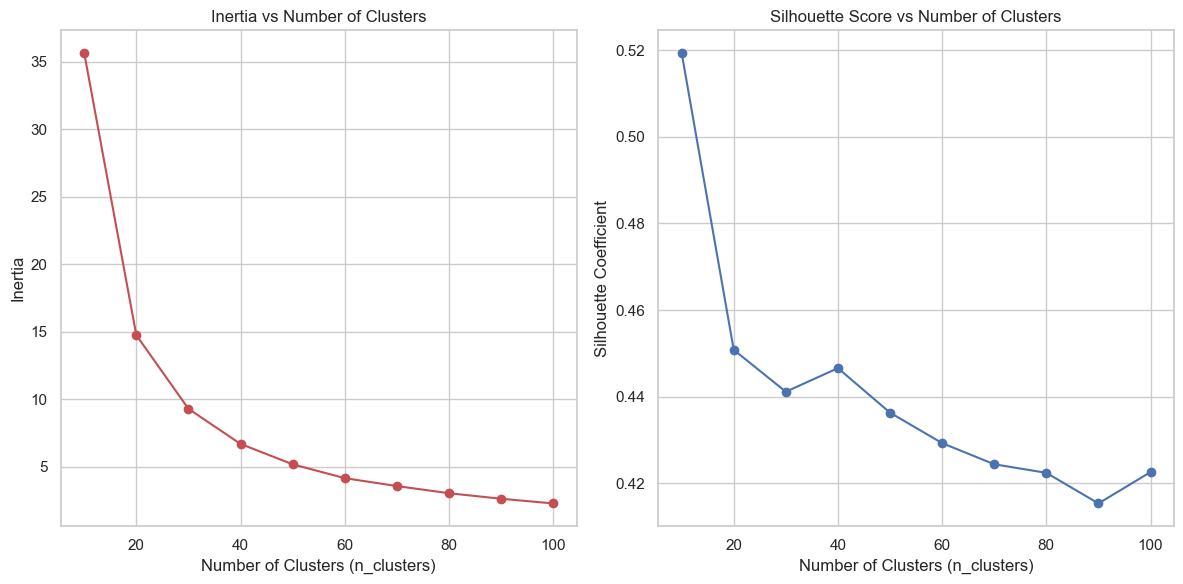

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_range = range(10, 101, 10)
inertia_values = []
silhouette_scores = []

# Compute inertia and silhouette score for each cluster count
for n_clusters in cluster_range:
    Geo_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    Geo_kmeans.fit(lat_lon)
    
    # Append inertia
    inertia_values.append(Geo_kmeans.inertia_)
    
    # Calculate silhouette score 
    silhouette_avg = silhouette_score(lat_lon, Geo_kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='r')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')  
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.show()

# N = 30 is Selected

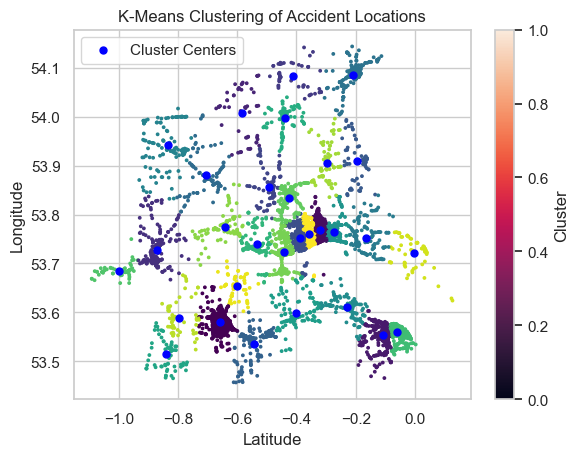

In [30]:
Geo_kmeans = KMeans(n_clusters=30, random_state=42) # Creates a Kmeans model with 30 clusters

df_region['Geo_Clusters'] = Geo_kmeans.fit_predict(lat_lon) # fits the model on latitude and longitude data and then predicts cluster 

# Create a scatter plot
plt.scatter(df_region['longitude'], df_region['latitude'], c=df_region['Geo_Clusters'], cmap='viridis', s=3)

# Adding cluster centers for reference
Geo_cluster_centers = Geo_kmeans.cluster_centers_
plt.scatter(Geo_cluster_centers[:, 0], Geo_cluster_centers[:, 1], c='blue', marker='o', s=25, label='Cluster Centers')

# Plot settings
plt.title('K-Means Clustering of Accident Locations')
plt.xlabel('Latitude') 
plt.ylabel('Longitude')  
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

## b) Accident Severity & Weather Conditions Clustering

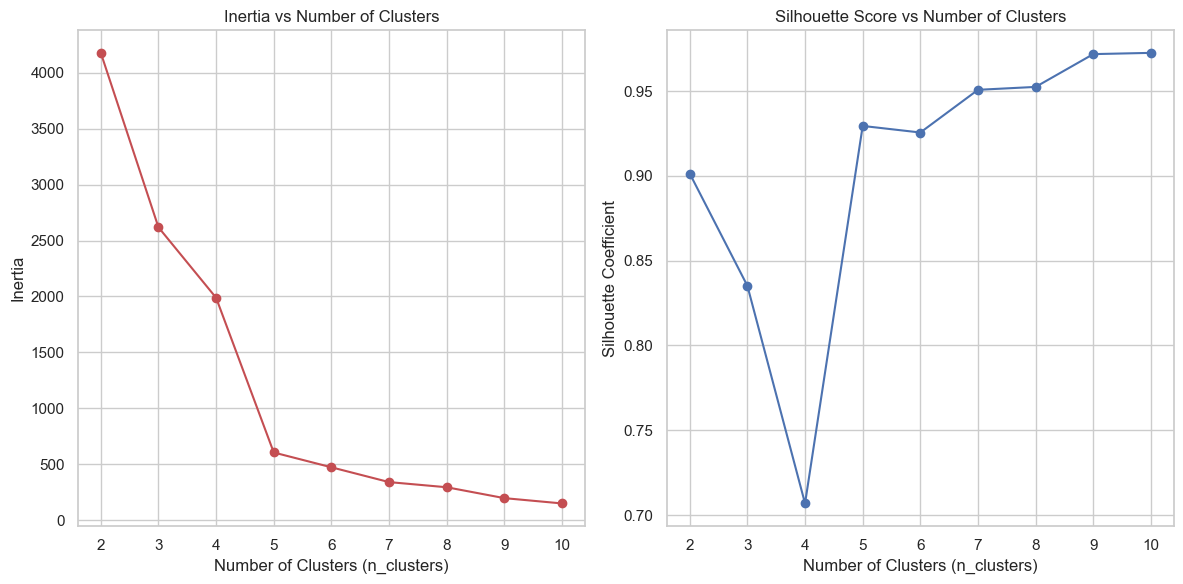

In [31]:
acc_weather = df_region[['accident_severity','weather_conditions']]
cluster_range = range(2, 11, 1)
inertia_values = []
silhouette_scores = []

# Compute inertia and silhouette score for each cluster count
for n_clusters in cluster_range:
    acc_wea_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    acc_wea_kmeans.fit(acc_weather)
    
    # Append inertia
    inertia_values.append(acc_wea_kmeans.inertia_)
    
    # Calculate silhouette score 
    silhouette_avg = silhouette_score(acc_weather, acc_wea_kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='r')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')  
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.show()

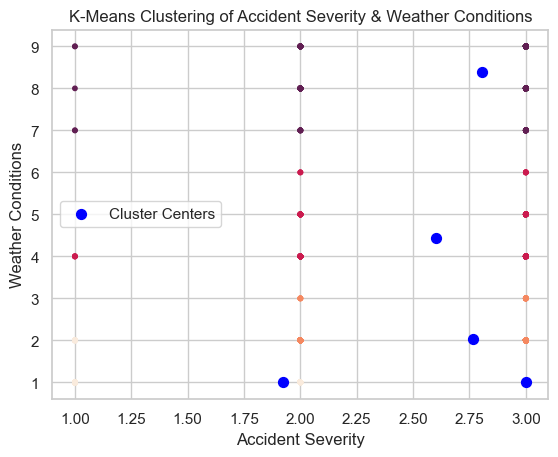

In [32]:
acc_wea_kmeans = KMeans(n_clusters=5, random_state=42)

df_region['acc_wea_Clusters'] = acc_wea_kmeans.fit_predict(acc_weather)

# Create a scatter plot
plt.scatter(df_region['accident_severity'], df_region['weather_conditions'], c=df_region['acc_wea_Clusters'], s=10)

# Adding cluster centers for reference
acc_wea_cluster_centers = acc_wea_kmeans.cluster_centers_
plt.scatter(acc_wea_cluster_centers[:, 0], acc_wea_cluster_centers[:, 1], c='blue', marker='o', s=50, label='Cluster Centers')

# Plot settings
plt.title('K-Means Clustering of Accident Severity & Weather Conditions')
plt.xlabel('Accident Severity') 
plt.ylabel('Weather Conditions')  
plt.legend()
plt.show()

## c) Light Condition & Road Surface Conditions Clustering

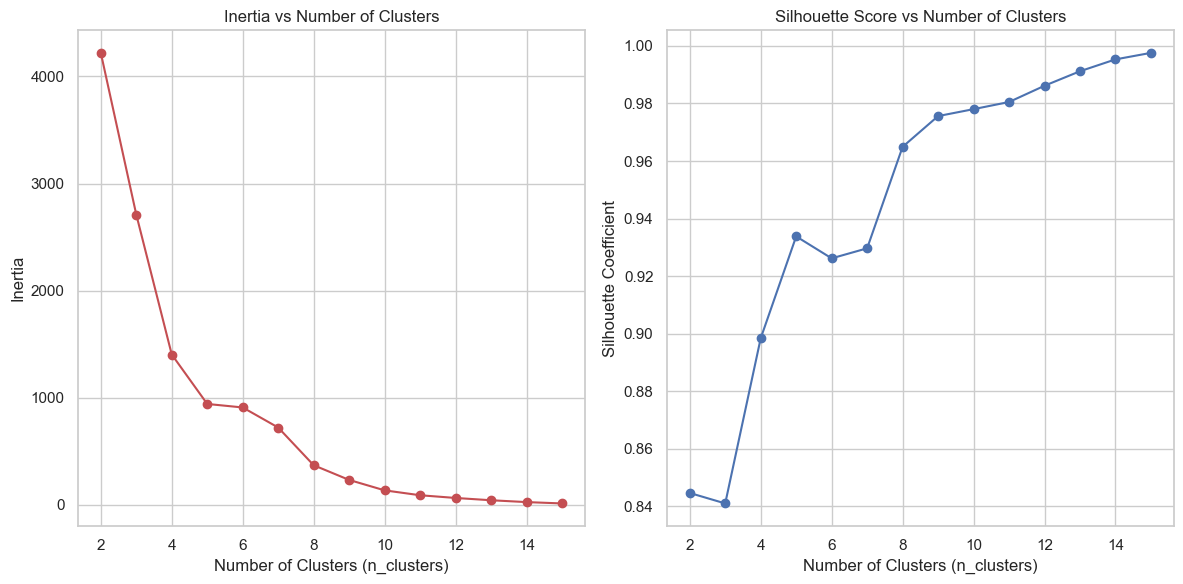

In [33]:
light_road = df_region[['light_conditions','road_surface_conditions']]

cluster_range = range(2, 16, 1)
inertia_values = []
silhouette_scores = []

# Compute inertia and silhouette score for each cluster count
for n_clusters in cluster_range:
    lightroad_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    lightroad_kmeans.fit(light_road)
    
    # Append inertia
    inertia_values.append(lightroad_kmeans.inertia_)
    
    # Calculate silhouette score 
    silhouette_avg = silhouette_score(light_road, lightroad_kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='r')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')  
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.show()

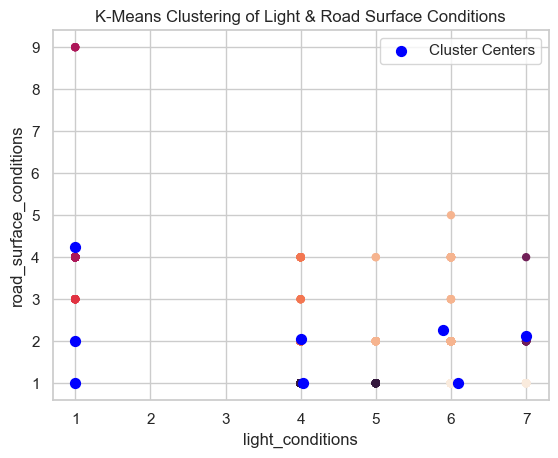

In [34]:
lightroad_kmeans = KMeans(n_clusters=8, random_state=42)

df_region['light_road_Clusters'] = lightroad_kmeans.fit_predict(light_road)

# Create a scatter plot
plt.scatter(df_region['light_conditions'], df_region['road_surface_conditions'], c=df_region['light_road_Clusters'], s=25)

# Adding cluster centers for reference
lightroad_cluster_centers = lightroad_kmeans.cluster_centers_
plt.scatter(lightroad_cluster_centers[:, 0], lightroad_cluster_centers[:, 1], c='blue', marker='o', s=50, label='Cluster Centers')

# Plot settings
plt.title('K-Means Clustering of Light & Road Surface Conditions')
plt.xlabel('light_conditions') 
plt.ylabel('road_surface_conditions')  
plt.legend()
plt.show()

## d) Accident Severity & Road Type

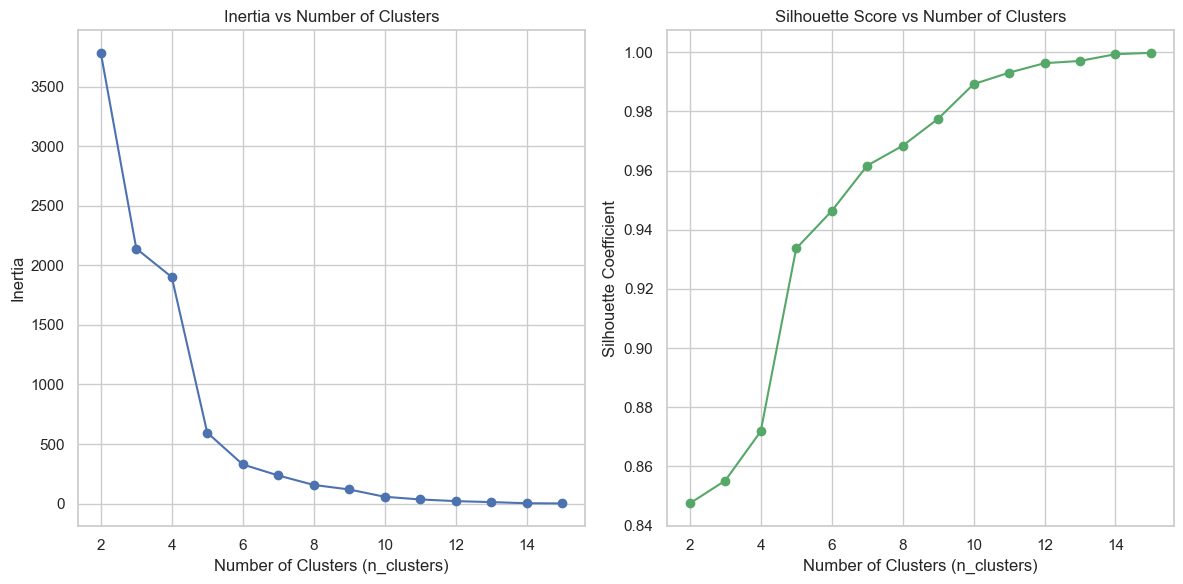

In [35]:
acc_road = df_region[['accident_severity','road_type']]

cluster_range = range(2, 16, 1)
inertia_values = []
silhouette_scores = []

# Compute inertia and silhouette score for each cluster count
for n_clusters in cluster_range:
    acc_road_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    acc_road_kmeans.fit(acc_road)
    
    # Append inertia
    inertia_values.append(acc_road_kmeans.inertia_)
    
    # Calculate silhouette score 
    silhouette_avg = silhouette_score(acc_road, acc_road_kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


# Plot the results
plt.figure(figsize=(12, 6))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')  
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.show()

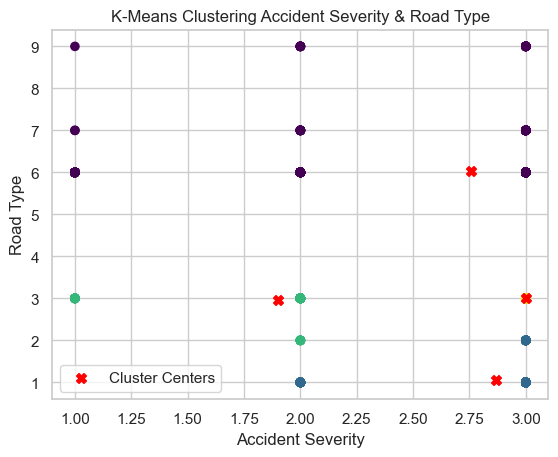

In [36]:
acc_road_kmeans = KMeans(n_clusters=4, random_state=42)

df_region['acc_road_Clusters'] = acc_road_kmeans.fit_predict(acc_road)

# Create a scatter plot
plt.scatter(df_region['accident_severity'], df_region['road_type'], c=df_region['acc_road_Clusters'], cmap='viridis', s=35)

# Adding cluster centers for reference
acc_road_cluster_centers = acc_road_kmeans.cluster_centers_
plt.scatter(acc_road_cluster_centers[:, 0], acc_road_cluster_centers[:, 1], c='red', marker='X', s=50, label='Cluster Centers')

# Plot settings
plt.title('K-Means Clustering Accident Severity & Road Type')
plt.xlabel('Accident Severity') 
plt.ylabel('Road Type')  
plt.legend()
plt.show()

# 6. Choose three policing areas by filtering the data using the "police_force" column, then create time series models to predict weekly accident counts for the upcoming year based on historical data from 2017 to 2019.

### City of London = 48, Derbyshire = 30, Humberside = 16

In [37]:
query = """
SELECT 
    accident_reference,
    date,
    police_force
FROM accident
WHERE police_force IN (48, 30, 16)
    AND date BETWEEN '01/01/2017' AND '31/12/2019';
"""

# Execute the query and load the results into a pandas DataFrame
df_policing_areas = pd.read_sql_query(query, con)

# Convert 'date' column from day/month/year format to datetime
df_policing_areas['date'] = pd.to_datetime(df_policing_areas['date'], format='%d/%m/%Y')

# Extract year and ISO week number
df_policing_areas['year'] = df_policing_areas['date'].dt.year
df_policing_areas['week'] = df_policing_areas['date'].dt.isocalendar().week

# Group by year and week to get weekly accident counts
weekly_accidents = df_policing_areas.groupby(['year', 'week']).size().reset_index(name='accident_count')

# Recreate the date index for the first day of each ISO week
weekly_accidents['date'] = pd.to_datetime(weekly_accidents['year'].astype(str) + weekly_accidents['week'].astype(str) + '1', format='%G%V%w')

# Ensure the resulting dataframe aligns with your dataset range
weekly_accidents = weekly_accidents[(weekly_accidents['date'] >= '2017-01-01') & (weekly_accidents['date'] <= '2020-12-31')]

# Set the datetime index
weekly_accidents = weekly_accidents.set_index('date')

In [38]:
weekly_accidents = weekly_accidents.drop(columns=['year', 'week'])
weekly_accidents.head()

,accident_count
date,
2017-01-02,83
2017-01-09,95
2017-01-16,77
2017-01-23,110
2017-01-30,67


# Visualising

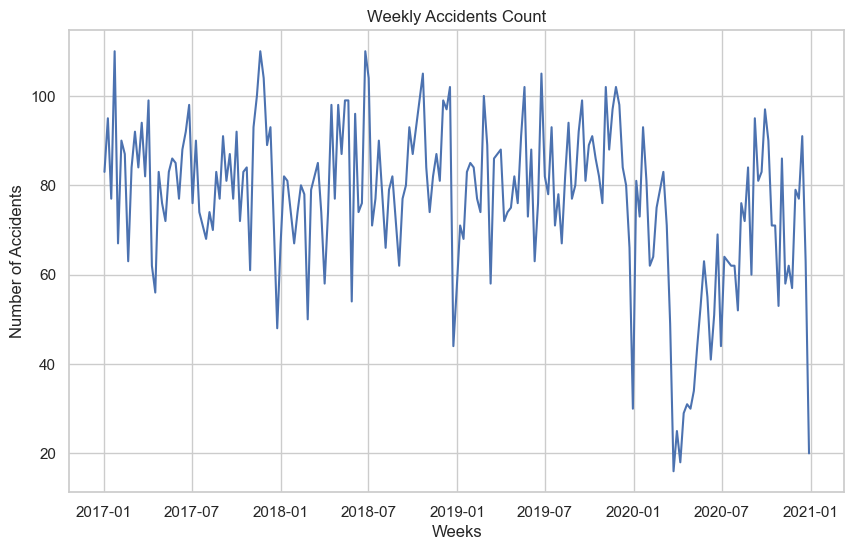

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_accidents.index, weekly_accidents['accident_count'], linestyle = '-', color = 'b')
plt.title('Weekly Accidents Count')
plt.xlabel('Weeks')
plt.ylabel('Number of Accidents')
plt.show()

# Decomposing

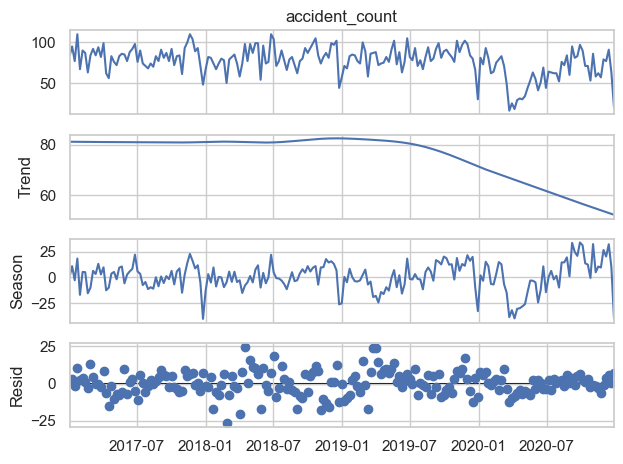

In [41]:
from statsmodels.tsa.seasonal import STL
stl = STL(weekly_accidents['accident_count'])  
result = stl.fit()
result.plot()
plt.show()

## Investigating Stationarity of Time Series

In [42]:
from statsmodels.tsa.stattools import adfuller
ADF_test = adfuller(weekly_accidents['accident_count'])
print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -4.4362222552356005; p-value 0.0002559537441102728


# Stationary!

## ACF & PACF Plot

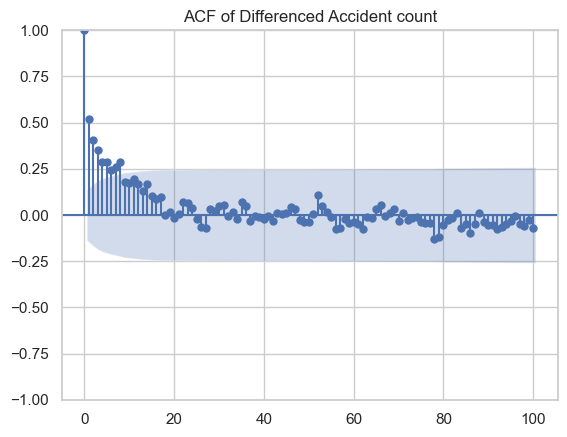

In [43]:
# Plot of ACF to understand the series
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(weekly_accidents[['accident_count']], lags=100)
plt.title('ACF of Differenced Accident count')
plt.show()

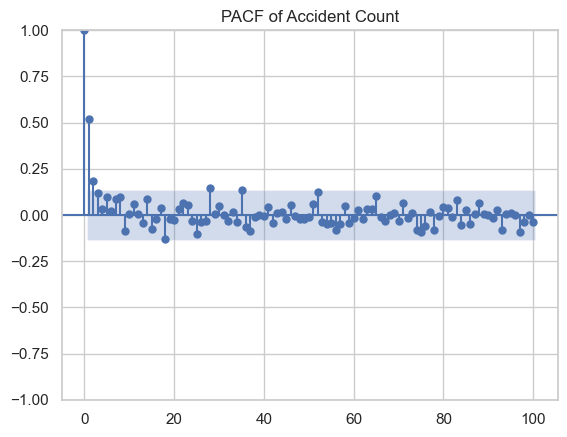

In [44]:
plot_pacf(weekly_accidents[['accident_count']], lags=100)
plt.title('PACF of Accident Count')
plt.show()

# Splitting the data into train and test set

In [45]:
# Split the data into train and test sets
train_data = weekly_accidents[weekly_accidents.index.year < 2020]  # Data from 2017 to 2019
test_data = weekly_accidents[weekly_accidents.index.year == 2020]  # Data from 2020

# Calculating AIC

In [46]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')



def calculate_arma_aic(train_data, p_range, q_range):
    """
    Function to calculate AIC for multiple ARIMA(p, 1, q) combinations.
    Stores the combinations of p, q, and their corresponding AIC values.
    """
    aic_results = []
    
    # Generate all combinations of p and q using product
    for p, q in product(p_range, q_range):
        try:
            # Fit the ARIMA model 
            model = ARIMA(train_data, order=(p, 0, q))
            model_fitted = model.fit()
            
            # Append results to the list
            aic_results.append((p, q, model_fitted.aic))
        except:
            # Skip if the model fitting fails (e.g., due to non-convergence)
            continue
    
    # Create a DataFrame to store results
    aic_df = pd.DataFrame(aic_results, columns=['p', 'q', 'AIC'])
    
    # Sort by AIC value in ascending order
    aic_df_sorted = aic_df.sort_values(by='AIC').reset_index(drop=True)
    
    return aic_df_sorted

In [47]:
from itertools import product
# Define the range for p and q
p_range = np.arange(0, 15, 1)  # For example, try p from 0 to 15
q_range = np.arange(0, 15, 1)  # Similarly, try q from 0 to 15

# Apply the function on the training data (you can use train_data from earlier)
aic_results = calculate_arma_aic(train_data['accident_count'], p_range, q_range)

In [48]:
aic_results.head()

,p,q,AIC
0,6,7,1246.485715
1,5,6,1247.012267
2,3,7,1248.182027
3,9,10,1248.234254
4,7,4,1248.239768


,lb_stat,lb_pvalue
1,0.212826,0.644561
2,0.355667,0.837082
3,0.819139,0.844884
4,1.104744,0.893519
5,1.307503,0.934158
6,1.513970,0.958561
7,3.223883,0.863548
8,3.898284,0.866182
9,5.590619,0.780088
10,5.647750,0.843939


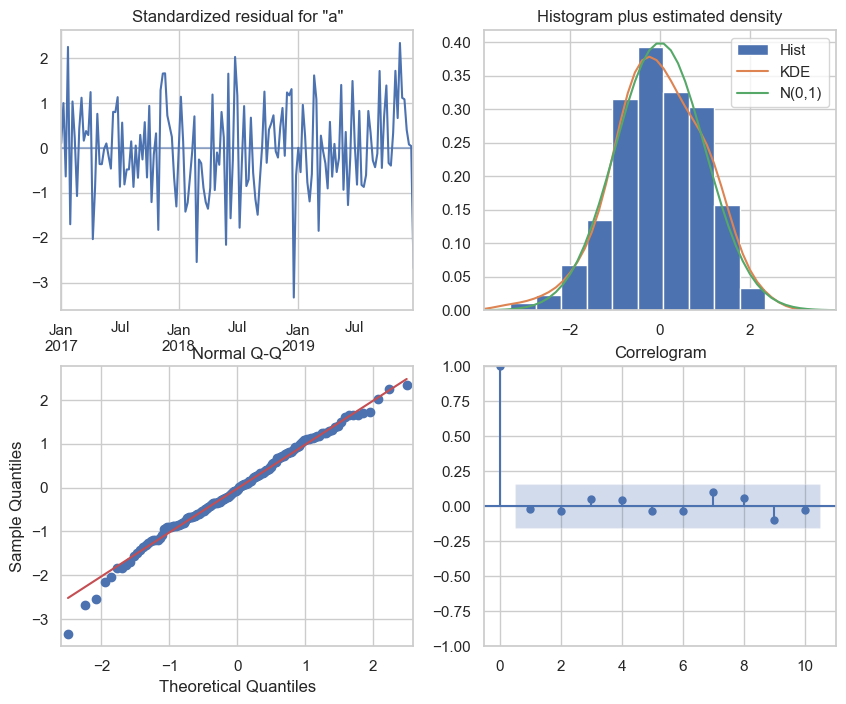

In [49]:
model_arima = ARIMA(train_data['accident_count'], order=(6, 0, 7))
model_arima_fitted = model_arima.fit()
# Plots the Q-Q plot
model_arima_fitted.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(model_arima_fitted.resid)

# Forecasting

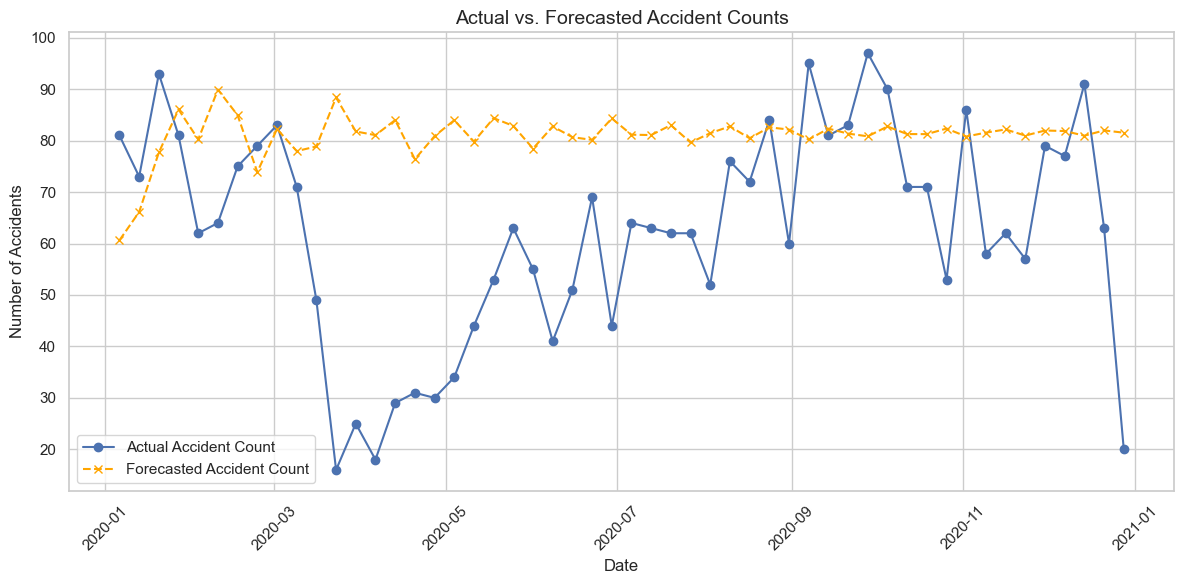

In [50]:
# Forecasting the test set using both naive_model (using the last values) and arima
len_test = len(test_data)
arima_pred = model_arima_fitted.get_forecast(len_test).predicted_mean.values

test_data['forecasted_accident_count'] = arima_pred

# Plot actual and forecasted accident counts
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['accident_count'], label='Actual Accident Count', marker='o')
plt.plot(test_data.index, test_data['forecasted_accident_count'], label='Forecasted Accident Count', marker='x', linestyle='--', color='orange')

# Add title and labels
plt.title('Actual vs. Forecasted Accident Counts', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)

# Rotate x-axis ticks for better visibility
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error
arima_rmse = mean_squared_error(test_data['accident_count'],test_data['forecasted_accident_count'],squared=False)
arima_rmse

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
rmse_percentage = (arima_rmse / test_data['accident_count'].mean()) * 100
print(f"RMSE as percentage of mean: {rmse_percentage}%")

# 7. Identify the three Local Super Output Areas (LSOAs) of Hull city that recorded the highest number of road accidents in the first three months of 2020, then employ a time series model to forecast daily accident occurrences for the upcoming month (e.g., July), leveraging data from the preceding six months (e.g., January to June) for these high-incident areas.

In [ ]:
query = """
    SELECT lsoa_of_accident_location, COUNT(*) AS accident_count
    FROM accident
    WHERE lsoa_of_accident_location BETWEEN 'E01012756' AND 'E01012918'
    AND substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2) 
        BETWEEN '2020-01-01' AND '2020-03-31'
    GROUP BY lsoa_of_accident_location
    ORDER BY accident_count DESC
    LIMIT 3;
"""

# Execute the query
cur.execute(query)

# Fetch and display the results
top_lsoas = cur.fetchall()
for row in top_lsoas:
    print(row)

## Time series model to forecast daily accident count

In [ ]:
# SQL query to get daily accident counts for specified LSOAs (E01012817, E01012848, E01012889)
query = """
SELECT 
    date,
    lsoa_of_accident_location,
    COUNT(*) AS accident_count
FROM accident
WHERE lsoa_of_accident_location IN ('E01012817', 'E01012848', 'E01012889')
  AND substr(date, 7, 4) || '-' || 
      substr(date, 4, 2) || '-' || 
      substr(date, 1, 2) BETWEEN '2020-01-01' AND '2020-03-31'
GROUP BY date, lsoa_of_accident_location
ORDER BY date;
"""

# Execute the query
cur.execute(query)

# Fetch the results
results = cur.fetchall()

In [ ]:
df = pd.DataFrame(results, columns=['date', 'lsoa_of_accident_location', 'accident_count'])

# Now proceed with the steps in pandas to pivot and prepare the data
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
daily_accidents_pivot = df.pivot(index='date', columns='lsoa_of_accident_location', values='accident_count')

# Generate the full date range from 01-01-2020 to 31-07-2020
full_date_range = pd.date_range(start='2020-01-01', end='2020-07-31')

# Reindex the pivot table to include all dates in the full date range
daily_accidents_pivot = daily_accidents_pivot.reindex(full_date_range, fill_value=0)

# Replace NaN values with 0 (for any missing data)
daily_accidents_pivot.fillna(0, inplace=True)

# Display the final pivot table
daily_accidents_pivot.head()

# Visualization

In [ ]:
# List of columns to plot
columns_to_plot = ['E01012817', 'E01012848', 'E01012889']

# Loop through each column and create a plot
for column in columns_to_plot:
    plt.figure(figsize=(10, 3))  # Set figure size
    plt.plot(daily_accidents_pivot.index, daily_accidents_pivot[column],linestyle = '-', color = 'r', label=column)
    plt.title(f"Line Plot for {column}")  # Title of the plot
    plt.xlabel("Date")  # X-axis label
    plt.ylabel("Accident Count")  # Y-axis label
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.grid(True)  # Add grid
    plt.legend()  # Add a legend
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()  # Display the plot

# Decomposition

In [ ]:
columns_to_decompose = ['E01012817', 'E01012848', 'E01012889'] 

#Loop through the columns and perform STL decomposition for each
for column in columns_to_decompose:
    stl = STL(daily_accidents_pivot[column])  
    result = stl.fit()
    result.plot()
    plt.show()

# Stationary Test

In [ ]:
def perform_adf_test_for_columns(df, columns):
    """
    This function performs the Augmented Dickey-Fuller (ADF) test for each column in the dataframe.
    """
    for column in columns:
        ADF_test = adfuller(df[column])[:2]
        print(f"ADF Test for {column}:")
        print(f"ADF Statistic: {ADF_test[0]}; p-value: {ADF_test[1]}")
        print("-" * 50)  

In [ ]:
columns_to_test = ['E01012817', 'E01012848', 'E01012889']
perform_adf_test_for_columns(daily_accidents_pivot, columns_to_test)

### Differencing E01012817 & E01012889

In [ ]:
# Applying differencing to for stationarity
diff_1_E01012817 = daily_accidents_pivot[['E01012817']].diff(1).dropna()
diff_1_E01012889 = daily_accidents_pivot[['E01012889']].diff(1).dropna()

In [ ]:
# Checking Stationary
ADF_test_E01012817 = adfuller(diff_1_E01012817)[:2]
print(f"ADF Statistic: {ADF_test_E01012817[0]}; p-value {ADF_test_E01012817[1]}")
ADF_test_E01012889 = adfuller(diff_1_E01012889)[:2]
print(f"ADF Statistic: {ADF_test_E01012889[0]}; p-value {ADF_test_E01012889[1]}")

### ACF & PACF Plots

# E01012817

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Combined ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# ACF Plot
plot_acf(diff_1_E01012817, lags=50, ax=axes[0])
axes[0].set_title('ACF of E01012817')

# PACF Plot
plot_pacf(diff_1_E01012817, lags=50, ax=axes[1])
axes[1].set_title('PACF of E01012817')

plt.tight_layout()
plt.show()

# E01012848

In [ ]:
# Combined ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# ACF Plot
plot_acf(daily_accidents_pivot["E01012848"], lags=50, ax=axes[0])
axes[0].set_title('ACF of E01012848')

# PACF Plot
plot_pacf(daily_accidents_pivot["E01012848"], lags=50, ax=axes[1])
axes[1].set_title('PACF of E01012848')

plt.tight_layout()
plt.show()

# E01012889

In [ ]:
# Combined ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# ACF Plot
plot_acf(diff_1_E01012889, lags=50, ax=axes[0])
axes[0].set_title('ACF of E01012889')

# PACF Plot
plot_pacf(diff_1_E01012889, lags=50, ax=axes[1])
axes[1].set_title('PACF of E01012889')

plt.tight_layout()
plt.show()

# Splitting the dataset

In [ ]:
train_data_lsoa = daily_accidents_pivot[daily_accidents_pivot.index.month <= 6]
test_data_lsoa = daily_accidents_pivot[daily_accidents_pivot.index.month >= 7]

# Employing ARMA for E01012848

In [ ]:
def calculate_best_arma_aic(train_data, p_range, q_range):
    """
    Function to calculate AIC for multiple ARMA(p, q) combinations.
    Stores the combinations of p, q, and their corresponding AIC values.
    Returns the combinations sorted by the lowest AIC.
    """
    aic_results = []
    
    # Generate all combinations of p and q using product
    for p, q in product(p_range, q_range):
        try:
            # Fit the ARMA model (ARIMA with d=0 means it's ARMA)
            model = ARIMA(train_data, order=(p, 0, q))  # d=0 for ARMA
            model_fitted = model.fit()
            
            # Append results to the list
            aic_results.append((p, q, model_fitted.aic))
        except:
            # Skip if the model fitting fails (e.g., due to non-convergence)
            continue
    
    # Create a DataFrame to store results
    best_aic_df = pd.DataFrame(aic_results, columns=['p', 'q', 'AIC'])
    
    # Sort by AIC value in ascending order
    best_aic_df_sorted = best_aic_df.sort_values(by='AIC').reset_index(drop=True)
    
    return best_aic_df_sorted

In [ ]:
from itertools import product
# Define the range of p and q for ARMA model orders
p_range = range(0, 16)  # Test AR orders from 0 to 15
q_range = range(0, 16)  # Test MA orders from 0 to 15

# Call the function to get the best ARMA model based on AIC
aic_results_E01012848 = calculate_best_arma_aic(train_data_lsoa['E01012848'], p_range, q_range)

# Employing ARIMA for E01012817 & E01012889

In [ ]:
def calculate_best_arima_aic(train_data, p_range, q_range):
    """
    Function to calculate AIC for multiple ARIMA(p, I, q) combinations.
    Stores the combinations of p, q, and their corresponding AIC values.
    Returns the combinations sorted by the lowest AIC.
    """
    aic_results = []
    
    # Generate all combinations of p and q using product
    for p, q in product(p_range, q_range):
        try:
            # Fit the ARIMA model 
            model = ARIMA(train_data, order=(p, 1, q))  
            model_fitted = model.fit()
            
            # Append results to the list
            aic_results.append((p, q, model_fitted.aic))
        except:
            # Skip if the model fitting fails (e.g., due to non-convergence)
            continue
    
    # Create a DataFrame to store results
    best_aic_df = pd.DataFrame(aic_results, columns=['p', 'q', 'AIC'])
    
    # Sort by AIC value in ascending order
    best_aic_df_sorted = best_aic_df.sort_values(by='AIC').reset_index(drop=True)
    
    return best_aic_df_sorted

In [ ]:
from itertools import product
# Define the range of p and q for ARMA model orders
p_range = range(0, 16)  # Test AR orders from 0 to 15
q_range = range(0, 16)  # Test MA orders from 0 to 15

# Call the function to get the best ARMA model based on AIC
aic_results_E01012817 = calculate_best_arima_aic(train_data_lsoa['E01012817'], p_range, q_range)

In [ ]:
aic_results_E01012817.head()

In [ ]:
from itertools import product
# Define the range of p and q for ARMA model orders
p_range = range(0, 16)  # Test AR orders from 0 to 15
q_range = range(0, 16)  # Test MA orders from 0 to 15

# Call the function to get the best ARMA model based on AIC
aic_results_E01012889 = calculate_best_arima_aic(train_data_lsoa['E01012889'], p_range, q_range)

In [ ]:
aic_results_E01012889.head()

# Building & Evaluating Model using Q-Q plot and Ljung-Box test.

# For E01012848

In [ ]:
def train_arma_model(train_data, p, q):
    """
    Function to train an ARMA(p, q) model and return the fitted model.
    """
    model = ARIMA(train_data, order=(p, 0, q))  # ARMA model with d=0 (no differencing)
    fitted_model = model.fit()  # Fit the model
    return fitted_model

In [ ]:
E01012848_arma_model = train_arma_model(train_data_lsoa['E01012848'], 5, 6)
from statsmodels.stats.diagnostic import acorr_ljungbox
# Plots the Q-Q plot
E01012848_arma_model.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
acorr_ljungbox(E01012848_arma_model.resid)

# For E01012817

In [ ]:
def train_arima_model(train_data, p, q):
    """
    Function to train an ARIMA(p, 1, q) model and return the fitted model.
    """
    model = ARIMA(train_data, order=(p, 1, q))  
    fitted_model = model.fit()  # Fit the model
    return fitted_model

In [ ]:
E01012817_arima_model = train_arima_model(train_data_lsoa['E01012817'], 15, 14)
# Plots the Q-Q plot
E01012817_arima_model.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
acorr_ljungbox(E01012817_arima_model.resid)

# For E01012889

In [ ]:
E01012889_arima_model = train_arima_model(train_data_lsoa['E01012889'], 2, 3)
# Plots the Q-Q plot
E01012889_arima_model.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
acorr_ljungbox(E01012889_arima_model.resid)

# Forecasting

In [ ]:
def forecast_and_plot_arma(test_data, model, column_name, forecast_column_name, forecast_length):
    """
    Forecast future values using an ARMA model and plot actual vs forecasted values.
    """
    #Forecasting the test set
    forecasted_values = model.get_forecast(forecast_length).predicted_mean.values
    test_data[forecast_column_name] = np.round(forecasted_values)  #Round forecasted values

    #Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[column_name], label='Actual Accident Count', marker='o')
    plt.plot(test_data.index, test_data[forecast_column_name], label='Forecasted Accident Count', marker='x', linestyle='--', color='orange')
    #Add title and labels
    plt.title(f'Actual vs. Forecasted Accident Counts for {column_name}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    # Add legend
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()

    return test_data

In [ ]:
forecast_length = len(test_data_lsoa)  

test_data_lsoa = forecast_and_plot_arma(
    test_data_lsoa, E01012848_arma_model, 'E01012848', 'forecasted_accident_count_E01012848', forecast_length
)

In [ ]:
def forecast_and_plot_arima(test_data, model, column_name, forecast_column_name, forecast_length):
    """
    Forecast future values using an ARIMA model and plot actual vs forecasted values.
    """
    #Forecasting the test set
    forecasted_values = model.get_forecast(forecast_length).predicted_mean.values
    test_data[forecast_column_name] = np.round(forecasted_values)  #Round forecasted values

    #Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[column_name], label='Actual Accident Count', marker='o')
    plt.plot(test_data.index, test_data[forecast_column_name], label='Forecasted Accident Count', marker='x', linestyle='--', color='orange')
    #Add title and labels
    plt.title(f'Actual vs. Forecasted Accident Counts for {column_name}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    # Add legend
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()

    return test_data

In [ ]:
forecast_length = len(test_data_lsoa)  

test_data_lsoa = forecast_and_plot_arima(
    test_data_lsoa, E01012817_arima_model, 'E01012817', 'forecasted_accident_count_E01012817', forecast_length
)

test_data_lsoa = forecast_and_plot_arima(
    test_data_lsoa, E01012889_arima_model, 'E01012889', 'forecasted_accident_count_E01012889', forecast_length
)

In [ ]:
from sklearn.metrics import mean_squared_error
def calculate_rmse(true_values, forecasted_values):
    """
    Function to calculate RMSE (Root Mean Squared Error)
    """
    return mean_squared_error(true_values, forecasted_values, squared=False)

arma_rmse_E01012817 = calculate_rmse(test_data_lsoa['E01012817'], test_data_lsoa['forecasted_accident_count_E01012817'])
arma_rmse_E01012848 = calculate_rmse(test_data_lsoa['E01012848'], test_data_lsoa['forecasted_accident_count_E01012848'])
arma_rmse_E01012889 = calculate_rmse(test_data_lsoa['E01012889'], test_data_lsoa['forecasted_accident_count_E01012889'])

print(f"RMSE for E01012817: {arma_rmse_E01012817}")
print(f"RMSE for E01012848: {arma_rmse_E01012848}")
print(f"RMSE for E01012889: {arma_rmse_E01012889}")


# 8) Construct a social network using the provided data and visualise the network, then provide the basic network characteristics, including numbers of nodes and edges, network density, average degree.

In [ ]:
import networkx as nx
edges = []
with open('facebook_combined.txt', 'r') as file:
    for line in file:
        node1, node2 = map(int, line.strip().split())
        edges.append((node1, node2))

In [ ]:
#Create a graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

#Basic visualization of the social network
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=20, node_color='red', alpha=0.5)
plt.title('Social Network Visualization')
plt.show()

In [ ]:
# Basic network characteristics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / num_nodes  # average degree

# Print network characteristics
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Network density: {density}')
print(f'Average degree: {avg_degree}')

# 9) Calculate the edge centrality of this network and plot the distribution of the edge centrality values.

In [ ]:
# Calculate Edge Betweenness Centrality
edge_betweenness = nx.edge_betweenness_centrality(G)
# Get the edge centrality values
centrality_values = list(edge_betweenness.values())

In [ ]:
# Plot the distribution of edge centrality values with improvements
plt.figure(figsize=(15, 8))

# Use a logarithmic scale for the y-axis
plt.hist(centrality_values, bins=200, color='skyblue', alpha=0.7, edgecolor='black')
plt.yscale('log')

# Add vertical line for mean value
mean_value = np.mean(centrality_values)
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.4f}')

# Zoom into the range around 0
plt.xlim([0, 0.05])

# Add titles and labels
plt.title('Distribution of Edge Betweenness Centrality (Zoomed In)', fontsize=16)
plt.xlabel('Edge Centrality', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

# 10. Use two community detection algorithms to detect the clusters/community within this social network, then compare the difference of results (the number of clusters and numbers of nodes in each cluster).

# Community Detection using Louvain & Label Propagation

In [ ]:
algorithms = [ "Louvain Modularity", "Label Propagation"]

# Dictionary to store communities detected by each algorithm
detected_communities = {}

# Apply each community detection algorithm and store the detected communities
for algorithm in algorithms:
    if algorithm == "Louvain Modularity":
        communities = nx.algorithms.community.greedy_modularity_communities(G)
    elif algorithm == "Label Propagation":
        communities = nx.algorithms.community.label_propagation_communities(G)
    detected_communities[algorithm] = communities
print ('community detection done')

In [ ]:
from statistics import mean
# Evaluate and compare the results
for algorithm, communities in detected_communities.items():
    modularity = nx.algorithms.community.modularity(G, communities)
    num_communities = len(communities)
    community_sizes = [len(community) for community in communities]
    average_community_size = average_community_size = mean(community_sizes)
    
    print(f"{algorithm}:")
    print(f"Modularity: {modularity}")
    print(f"Number of Communities: {num_communities}")
    print(f"Community Sizes: {community_sizes}")
    print(f"Average Community Size: {average_community_size}\n")

# Visualization

In [ ]:
# Visualize community structures
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
for i, (algorithm, communities) in enumerate(detected_communities.items()):
    plt.subplot(2, 2, i+1)
    colors = [f'C{i}' for i in range(len(communities))]
    for j, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[j], node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(algorithm)
plt.tight_layout()
plt.show()